In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd

Generate a synthetic signal with and without noise


- $s_1(t) = \sin(2\pi \cdot 0.1 \cdot t)$  
- $s_2(t) = s_1(t) + 0.5 \cdot \sin(2\pi \cdot 0.3 \cdot t)$  
- $s_3(t) = s_2(t) + 0.3 \cdot \sin(2\pi \cdot 0.4 \cdot t)$  

- Clean signals stacked:

$$
\text{CleanSignals}(t) =
\begin{bmatrix}
s_1(t) \\
s_2(t) \\
s_3(t)
\end{bmatrix}
$$

- Additive Gaussian noise:

$$
\text{Noise}(t) \sim \mathcal{N}(0, \sigma^2), \quad \text{shape matches CleanSignals}
$$

- Noised signals:

$$
\text{NoisedSignals}(t) = \text{CleanSignals}(t) + \text{Noise}(t)
$$

In [ ]:
# -----------------------
# Signal Generator
# -----------------------
def generate_signals(n_samples=1000, noise_std=0.5):
    t = np.arange(n_samples)

    # Clean oscillatory signals
    s1 = np.sin(2 * np.pi * 0.1 * t)
    s2 = s1 + 0.5 * np.sin(2 * np.pi * 0.3 * t)
    s3 = s2 + 0.3 * np.sin(2 * np.pi * 0.4 * t)
    clean_signals = np.vstack([s1, s2, s3])

    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, clean_signals.shape)
    noised_signals = clean_signals + noise

    return clean_signals, noised_signals

### MSSA: Time Series Embedding

**Function:** `embed_time_series(X, M)`

This function performs trajectory matrix construction (also known as time-delay embedding) for **Multivariate Singular Spectrum Analysis (MSSA)**.

#### Inputs:
- $X \in \mathbb{R}^{L \times N}$: Multivariate time series with $L$ variables and $N$ time points.
- $M$: Embedding dimension (window length).

#### Computations:
- $K = N - M + 1$: Number of columns in the embedded matrix.
- Output matrix shape: $(L \cdot M) \times K$

#### Output:
- Trajectory matrix $T \in \mathbb{R}^{(L \cdot M) \times K}$, constructed by sliding a window of size $M$ over each row (time series) in $X$ and stacking the resulting lagged segments.

Each block of $M$ consecutive values from a single time series is flattened and stacked vertically.

#### Mathematical Representation:

For each time series $X_l$ (row $l$ of $X$), the trajectory block is:

$$
\text{Block}_l = 
\begin{bmatrix}
X_l[0] & X_l[1] & \cdots & X_l[K-1] \\
X_l[1] & X_l[2] & \cdots & X_l[K] \\
\vdots & \vdots & \ddots & \vdots \\
X_l[M-1] & X_l[M] & \cdots & X_l[M+K-2]
\end{bmatrix}
$$

These blocks are then stacked for all $l = 1, \ldots, L$:

$$
T = 
\begin{bmatrix}
\text{Block}_1 \\
\text{Block}_2 \\
\vdots \\
\text{Block}_L
\end{bmatrix}
$$


In [ ]:
# -----------------------
# MSSA Helper Functions
# -----------------------
def embed_time_series(X, M):
    L, N = X.shape
    K = N - M + 1
    trajectory = np.zeros((L * M, K))
    for l in range(L):
        for i in range(M):
            trajectory[l * M + i] = X[l, i:i + K]
    return trajectory

### Detrended Fluctuation Analysis (DFA)

**Function:** `compute_dfa(signal, min_scale=4, max_scale=50)`

This function estimates the **scaling exponent (α)** of a signal using DFA, a method used to quantify long-range temporal correlations in non-stationary time series.

---

#### **Steps:**

1. **Profile (cumulative sum):**

   Center the signal and compute the cumulative sum (profile):

   $$
   Y(i) = \sum_{k=1}^{i} \left( x(k) - \bar{x} \right)
   $$

2. **Divide into non-overlapping segments** of length $s$ (scale), where $s$ is logarithmically spaced between `min_scale` and `max_scale`.

3. **Detrending:**

   For each segment of size $s$:
   - Fit a **linear trend** $y_{\text{fit}}(i)$ using least squares (first-degree polynomial).
   - Subtract the trend from the segment.
   - Compute the **root-mean-square (RMS)** fluctuation:

     $$
     F(s) = \sqrt{ \frac{1}{s} \sum_{i=1}^{s} \left( Y(i) - y_{\text{fit}}(i) \right)^2 }
     $$

4. **Average over all segments** for each scale $s$ to get a fluctuation value $F(s)$.

5. **Log–log plot and slope:**

   Fit a line to the log–log plot:

   $$
   \log F(s) \sim \alpha \log s
   $$

   The slope $\alpha$ is the **DFA exponent**, which characterizes the correlation properties:
   - $\alpha = 0.5$: uncorrelated (white noise)
   - $0.5 < \alpha < 1$: long-range correlations
   - $\alpha = 1$: $1/f$ noise
   - $\alpha > 1$: nonstationary trends

---

#### **Returns:**
- The **DFA exponent** $\alpha$, estimated as the slope of the linear fit on the $\log$–$\log$ scale.


In [ ]:
def compute_dfa(signal, min_scale=4, max_scale=50):
    N = len(signal)
    scales = np.floor(np.logspace(np.log10(min_scale), np.log10(max_scale), num=20)).astype(int)
    fluctuations = []
    profile = np.cumsum(signal - np.mean(signal))

    for scale in scales:
        segments = N // scale
        rms = []
        for i in range(segments):
            idx = slice(i * scale, (i + 1) * scale)
            segment = profile[idx]
            x = np.arange(scale)
            coeffs = np.polyfit(x, segment, deg=1)
            trend = np.polyval(coeffs, x)
            rms.append(np.sqrt(np.mean((segment - trend) ** 2)))
        fluctuations.append(np.mean(rms))

    log_scales = np.log(scales)
    log_flucts = np.log(fluctuations)
    slope, _ = np.polyfit(log_scales, log_flucts, 1)
    return slope

### MSSA-DFA Denoising

**Function:** `mssa_dfa_denoise(X, M=30, dfa_threshold=1.0)`

This function applies **Multivariate Singular Spectrum Analysis (MSSA)** followed by **Detrended Fluctuation Analysis (DFA)** to selectively reconstruct signal components with long-range temporal correlations, effectively denoising multivariate time series data.

---

#### **Inputs:**

- $X \in \mathbb{R}^{L \times N}$: Multivariate signal with $L$ time series of length $N$.
- $M$: Embedding window length.
- `dfa_threshold`: Minimum DFA exponent ($\alpha$) for retaining a component.

---

#### **Steps:**

1. **Trajectory Matrix Construction:**

   Use time-delay embedding (see `embed_time_series`) to convert $X$ into a trajectory matrix:

   $$
   T \in \mathbb{R}^{(L \cdot M) \times K}, \quad \text{where } K = N - M + 1
   $$

2. **Singular Value Decomposition (SVD):**

   Decompose the trajectory matrix:

   $$
   T = U \Sigma V^T
   $$

   Where each rank-1 component corresponds to:

   $$
   RC_k = \Sigma_k \cdot U_k V_k^T
   $$

   The $U_k$ is reshaped into $(L, M)$ and used to reconstruct the $k$-th component $RC_k$.

3. **Reconstruction of Components:**

   Each reconstructed component is averaged along diagonals to form a denoised time series per variable.

4. **DFA-Based Filtering:**

   For each component $RC_k$ and each time series $l = 1, \dots, L$, compute the DFA exponent $\alpha$.  
   If **any** 
   
   $\alpha > \text{dfa\_threshold}$, retain the component:

   $$
   \alpha_k^{(l)} = \text{DFA}(RC_k^{(l)})
   $$

5. **Summation of Retained Components:**

   Denoised signal:

   $$
   X_{\text{denoised}} = \sum_{k \in \text{selected}} RC_k
   $$

---

#### **Output:**

- $X_{\text{denoised}}$: The reconstructed and denoised multivariate signal.
- If no components pass the DFA threshold, a zero matrix is returned with a warning.

---

#### **Note:**

DFA is used here as a nonlinear filter to retain components exhibiting **long-range correlations**, making this method effective for separating signal from stochastic or short-memory noise.


In [ ]:
# -----------------------
# MSSA-DFA Denoising Core
# -----------------------
def mssa_dfa_denoise(X, M=30, dfa_threshold=1.0):
    L, N = X.shape
    trajectory = embed_time_series(X, M)
    U, Sigma, VT = svd(trajectory, full_matrices=False)

    RCs = []
    for k in range(U.shape[1]):
        Uk = U[:, k].reshape((L, M))
        Sk = Sigma[k]
        Vk = VT[k, :]
        RC_k = np.zeros((L, N))
        for l in range(L):
            for i in range(N - M + 1):
                RC_k[l, i:i + M] += Sk * Uk[l, :] * Vk[i]
        RC_k /= M
        RCs.append(RC_k)

    # DFA filtering
    selected = []
    for k, RC_k in enumerate(RCs):
        keep = False
        for l in range(L):
            alpha = compute_dfa(RC_k[l])
            if alpha > dfa_threshold:
                keep = True
        if keep:
            selected.append(RC_k)

    if not selected:
        print("⚠️ No components passed DFA threshold. Try lowering the threshold.")
        return np.zeros_like(X)

    denoised = np.sum(selected, axis=0)
    return denoised

In [ ]:
# -----------------------
# Plotting Function
# -----------------------
def plot_results(clean, noisy, denoised):
    fig, axs = plt.subplots(3, 1, figsize=(14, 8))
    t = np.arange(clean.shape[1])
    for i in range(3):
        axs[i].plot(t, clean[i], label="Ground Truth", color='black', linewidth=2)
        axs[i].plot(t, noisy[i], label="Noisy Signal", color='red', alpha=1.0)
        axs[i].plot(t, denoised[i], label="Denoised Output", color='green')
        axs[i].set_title(f"Signal {i+1}")
        axs[i].legend(loc='upper right')
    plt.tight_layout()
    plt.show()

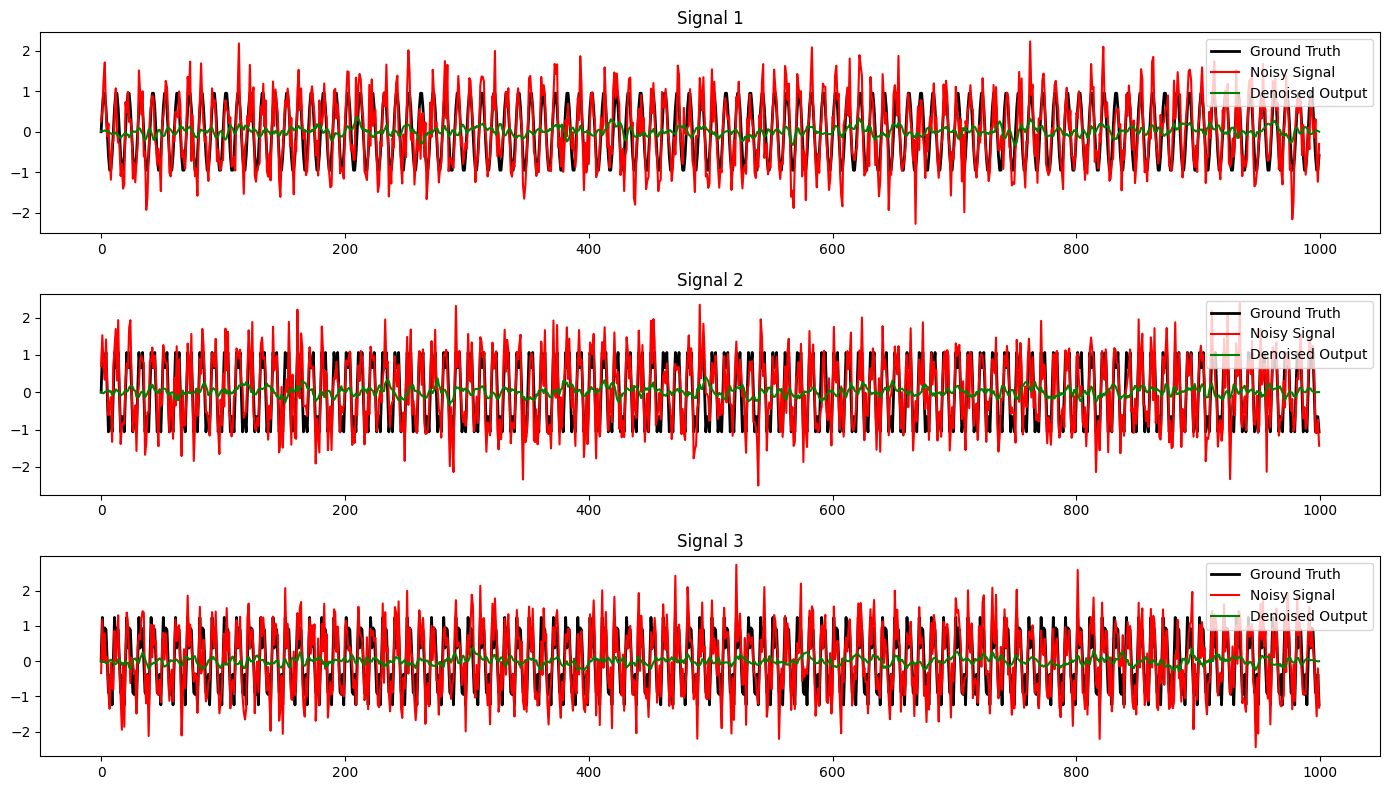

In [4]:
# -----------------------
# Main Execution
# -----------------------
if __name__ == "__main__":
    np.random.seed(42)
    clean_signals, noisy_signals = generate_signals(n_samples=1000, noise_std=0.5)
    denoised_signals = mssa_dfa_denoise(noisy_signals, M=30, dfa_threshold=1.0)
    plot_results(clean_signals, noisy_signals, denoised_signals)

In [ ]:
from sklearn.metrics import mean_squared_error

# -----------------------
# RMSE Utility
# -----------------------
def compute_rmse(true_signal, denoised_signal):
    return np.sqrt(np.mean((true_signal - denoised_signal)**2, axis=1))  # per signal

# -----------------------
# Threshold Optimizer
# -----------------------
def find_best_dfa_threshold(clean_signals, noisy_signals, thresholds=np.linspace(0.5, 1.5, 11), M=30, verbose=True):
    best_rmse = np.inf
    best_threshold = None
    rmse_scores = []

    for threshold in thresholds:
        denoised = mssa_dfa_denoise(noisy_signals, M=M, dfa_threshold=threshold)
        rmse_per_signal = compute_rmse(clean_signals, denoised)
        avg_rmse = np.mean(rmse_per_signal)
        rmse_scores.append(avg_rmse)

        if verbose:
            print(f"DFA threshold: {threshold:.2f} → Avg RMSE: {avg_rmse:.4f}")

        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_threshold = threshold

    if verbose:
        print(f"\n Best threshold: {best_threshold:.2f} with Avg RMSE: {best_rmse:.4f}")

    # Optional: plot
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 4))
        plt.plot(thresholds, rmse_scores, marker='o')
        plt.xlabel("DFA Threshold")
        plt.ylabel("Avg RMSE")
        plt.title("DFA Threshold vs Denoising RMSE")
        plt.grid(True)
        plt.show()
    except:
        pass

    return best_threshold, rmse_scores

DFA threshold: 0.10 → Avg RMSE: 0.5426
DFA threshold: 0.17 → Avg RMSE: 0.4971
DFA threshold: 0.25 → Avg RMSE: 0.4644
DFA threshold: 0.32 → Avg RMSE: 0.4428
DFA threshold: 0.39 → Avg RMSE: 0.4230
DFA threshold: 0.47 → Avg RMSE: 0.4066
DFA threshold: 0.54 → Avg RMSE: 0.3945
DFA threshold: 0.62 → Avg RMSE: 0.3744
DFA threshold: 0.69 → Avg RMSE: 0.3654
DFA threshold: 0.76 → Avg RMSE: 0.3596
DFA threshold: 0.84 → Avg RMSE: 0.7885
DFA threshold: 0.91 → Avg RMSE: 0.7814
DFA threshold: 0.98 → Avg RMSE: 0.7801
DFA threshold: 1.06 → Avg RMSE: 0.7760
DFA threshold: 1.13 → Avg RMSE: 0.7750
DFA threshold: 1.21 → Avg RMSE: 0.7743
DFA threshold: 1.28 → Avg RMSE: 0.7743
DFA threshold: 1.35 → Avg RMSE: 0.7734
DFA threshold: 1.43 → Avg RMSE: 0.7734
DFA threshold: 1.50 → Avg RMSE: 0.7725

✅ Best threshold: 0.76 with Avg RMSE: 0.3596


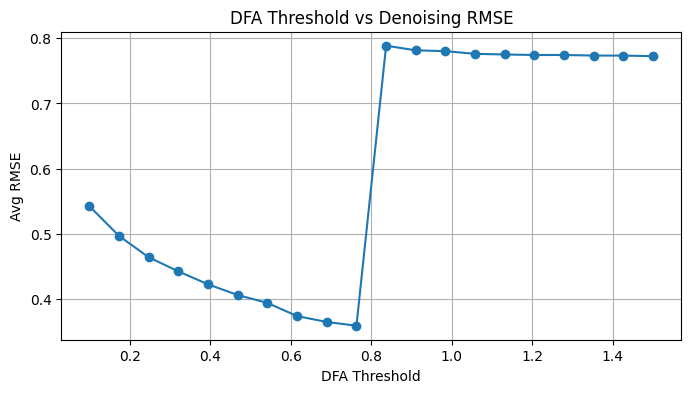

/tmp/ipykernel_94235/2685787546.py:108: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_94235/2685787546.py:108: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_94235/2685787546.py:108: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


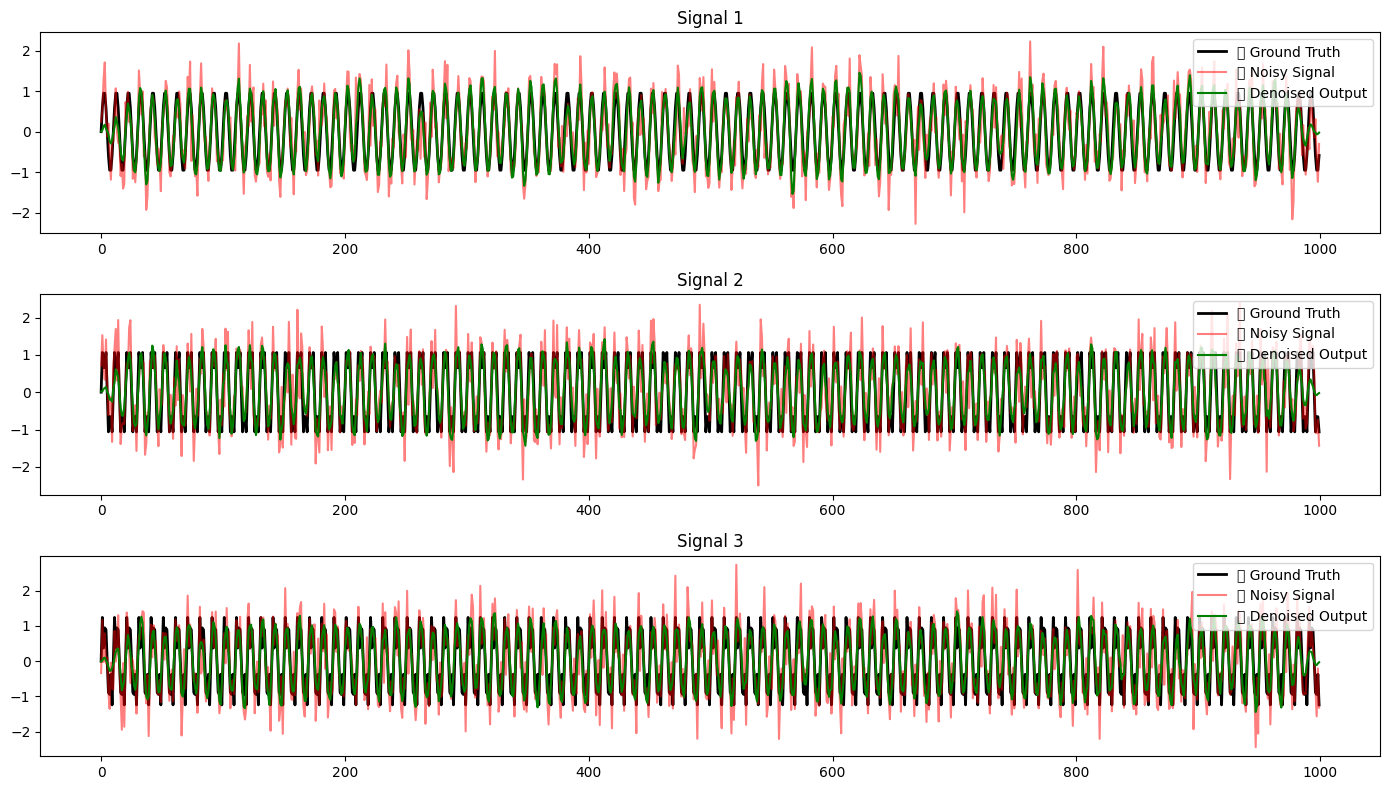

In [ ]:
    # Find best DFA threshold
    best_thresh, _ = find_best_dfa_threshold(clean_signals, noisy_signals, thresholds=np.linspace(0.1, 1.5, 20), M=30)

    # Use best threshold for final denoising
    final_denoised = mssa_dfa_denoise(noisy_signals, M=30, dfa_threshold=best_thresh)

    # Plot comparison
    plot_results(clean_signals, noisy_signals, final_denoised)

In [6]:
# Main logic: compute DFA exponents of all reconstructed components
def analyze_rc_dfa(noisy_signals, M=30):
    L, N = noisy_signals.shape
    trajectory = embed_time_series(noisy_signals, M)
    U, Sigma, VT = svd(trajectory, full_matrices=False)

    dfa_exponents = []
    for k in range(U.shape[1]):
        Uk = U[:, k].reshape((L, M))
        Sk = Sigma[k]
        Vk = VT[k, :]
        RC_k = np.zeros((L, N))
        for l in range(L):
            for i in range(N - M + 1):
                RC_k[l, i:i + M] += Sk * Uk[l, :] * Vk[i]
        RC_k /= M

        # Compute average DFA exponent across all signals for this RC
        avg_dfa = np.mean([compute_dfa(RC_k[l]) for l in range(L)])
        dfa_exponents.append(avg_dfa)

    return dfa_exponents

# Generate data and analyze
_, noisy_signals = generate_signals(n_samples=1000, noise_std=0.5)
dfa_exponents = analyze_rc_dfa(noisy_signals, M=30)

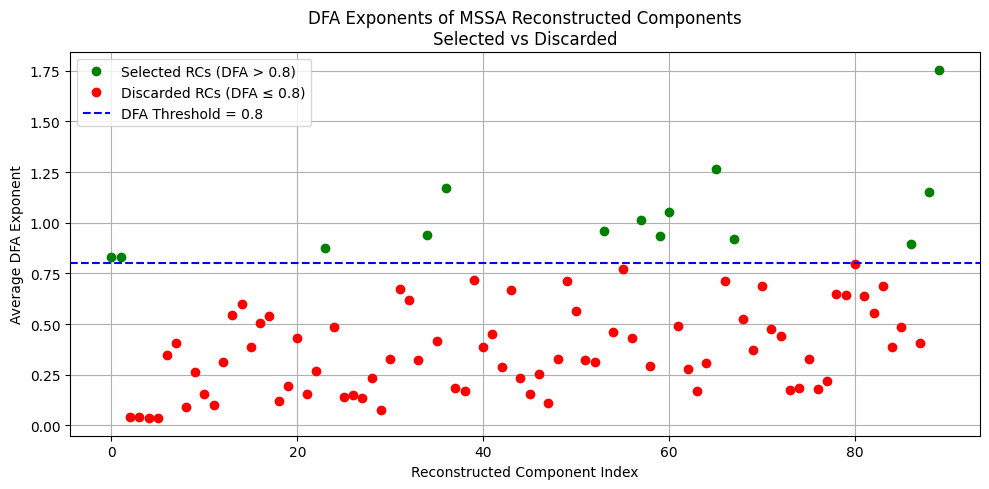

In [7]:
# Determine which RCs would be selected at threshold = 0.8
threshold = 0.8
selected_indices = [i for i, alpha in enumerate(dfa_exponents) if alpha > threshold]
discarded_indices = [i for i in range(len(dfa_exponents)) if i not in selected_indices]

# Plot with selected vs discarded RCs color-coded
plt.figure(figsize=(10, 5))
plt.plot(selected_indices, [dfa_exponents[i] for i in selected_indices], 'go', label='Selected RCs (DFA > 0.8)')
plt.plot(discarded_indices, [dfa_exponents[i] for i in discarded_indices], 'ro', label='Discarded RCs (DFA ≤ 0.8)')
plt.axhline(threshold, color='blue', linestyle='--', label='DFA Threshold = 0.8')
plt.xlabel("Reconstructed Component Index")
plt.ylabel("Average DFA Exponent")
plt.title("DFA Exponents of MSSA Reconstructed Components\nSelected vs Discarded")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd

def plot_explained_variance_with_dfa(noisy_signals, dfa_exponents, dfa_threshold=0.8, M=30):
    """
    Plots explained variance per component with DFA filtering overlay.
    
    Parameters:
    - noisy_signals: multivariate time series (shape: [n_signals, n_samples])
    - dfa_exponents: list of DFA exponents for each RC
    - dfa_threshold: threshold to distinguish between signal and noise
    - M: embedding window length
    """
    # Step 1: Perform MSSA
    def embed_time_series(X, M):
        L, N = X.shape
        K = N - M + 1
        trajectory = np.zeros((L * M, K))
        for l in range(L):
            for i in range(M):
                trajectory[l * M + i] = X[l, i:i + K]
        return trajectory

    trajectory = embed_time_series(noisy_signals, M)
    _, Sigma, _ = svd(trajectory, full_matrices=False)

    # Step 2: Compute explained and cumulative variance
    explained_variance = (Sigma ** 2) / np.sum(Sigma ** 2)
    cumulative_variance = np.cumsum(explained_variance)
    component_indices = np.arange(len(Sigma))

    # Step 3: Create overlay plot
    plt.figure(figsize=(12, 6))
    plt.bar(component_indices, explained_variance, color='lightgray', label='Explained Variance')
    plt.scatter(
        component_indices,
        explained_variance,
        c=['green' if alpha > dfa_threshold else 'red' for alpha in dfa_exponents],
        label='DFA > {:.2f} (green) | ≤ {:.2f} (red)'.format(dfa_threshold, dfa_threshold),
        zorder=3
    )
    plt.plot(component_indices, cumulative_variance, color='blue', linestyle='--', label='Cumulative Variance')
    
    plt.xlabel("Component Index")
    plt.ylabel("Variance Ratio")
    plt.title("Explained Variance with DFA Filtering Overlay")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


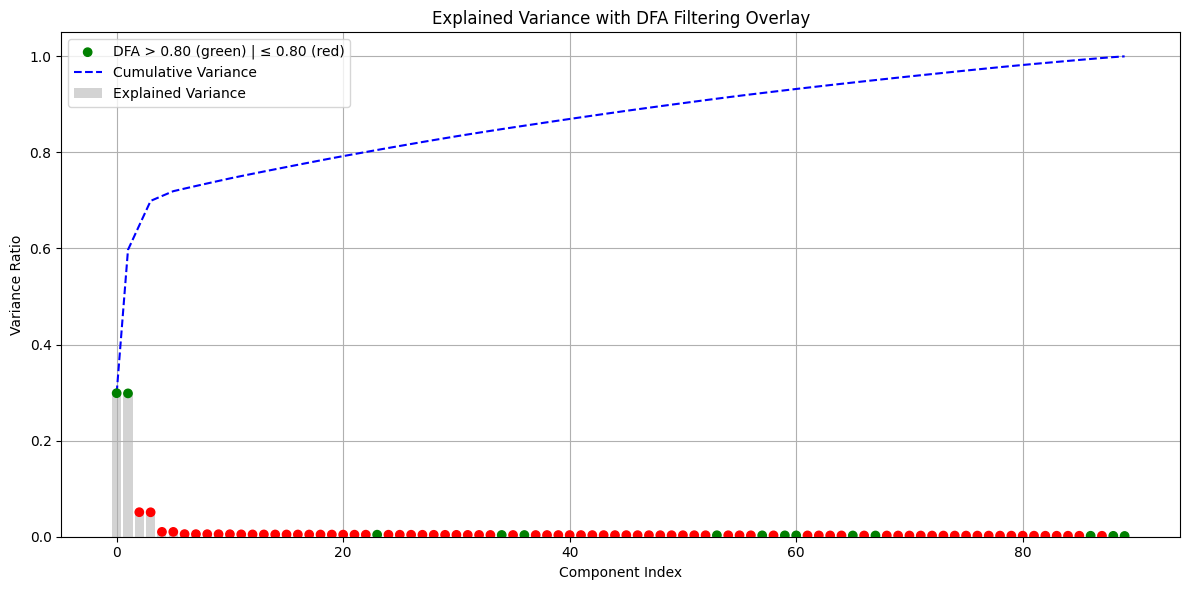

In [11]:
plot_explained_variance_with_dfa(noisy_signals, dfa_exponents, dfa_threshold=0.8, M=30)


In [15]:
def mssa_dfa_dual_filter_denoise(X, M=30, dfa_threshold=0.8, variance_threshold=0.005):
    """
    Apply MSSA and retain only components that pass both DFA and variance thresholds.
    
    Parameters:
    - X: multivariate time series (L x N)
    - M: window size
    - dfa_threshold: minimum DFA exponent to consider a component as signal
    - variance_threshold: minimum explained variance ratio to consider significant
    """
    L, N = X.shape
    K = N - M + 1

    # 1. MSSA
    trajectory = embed_time_series(X, M)
    U, Sigma, VT = svd(trajectory, full_matrices=False)

    explained_variance = (Sigma ** 2) / np.sum(Sigma ** 2)

    RCs = []
    dfa_exponents = []
    for k in range(U.shape[1]):
        Uk = U[:, k].reshape((L, M))
        Sk = Sigma[k]
        Vk = VT[k, :]
        RC_k = np.zeros((L, N))
        for l in range(L):
            for i in range(K):
                RC_k[l, i:i + M] += Sk * Uk[l, :] * Vk[i]
        RC_k /= M

        # Compute average DFA for this RC
        avg_dfa = np.mean([compute_dfa(RC_k[l]) for l in range(L)])
        dfa_exponents.append(avg_dfa)
        RCs.append(RC_k)

    # 2. Apply dual filtering
    selected = []
    for k, (rc, alpha) in enumerate(zip(RCs, dfa_exponents)):
        if alpha > dfa_threshold and explained_variance[k] > variance_threshold:
            selected.append(rc)

    if not selected:
        print("No components passed both thresholds. Try lowering them.")
        return np.zeros_like(X), [], []

    denoised = np.sum(selected, axis=0)
    return denoised, dfa_exponents, explained_variance


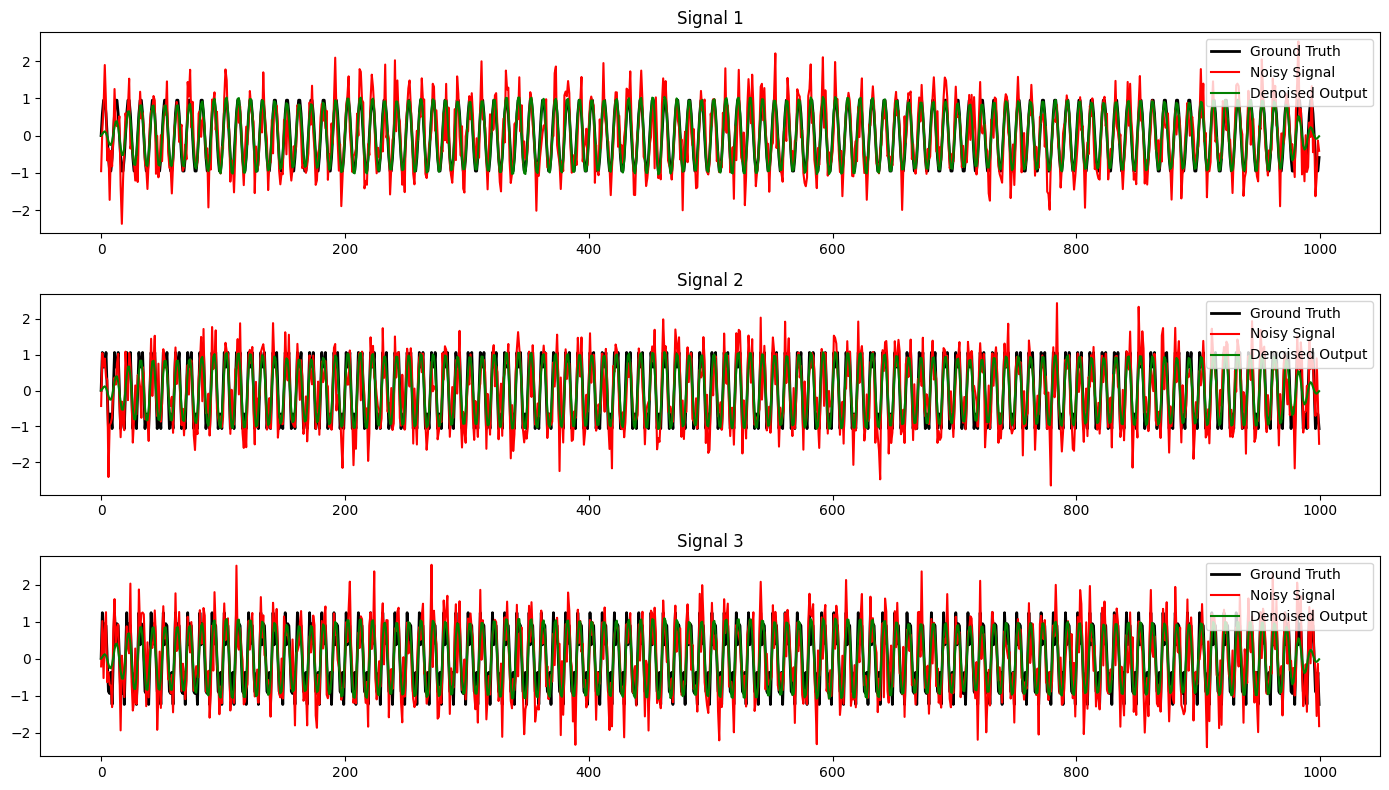

In [13]:
denoised, dfa_exponents, explained_var = mssa_dfa_dual_filter_denoise(
    noisy_signals, M=30, dfa_threshold=0.8, variance_threshold=0.005
)

plot_results(clean_signals, noisy_signals, denoised)
